In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)


사용하는 Device :  cuda


In [3]:

# train loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='/home/pojaehanwer/Downloads/DATASET_PCB/train/', transform = transformer)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle = True, num_workers = 2)

print(trainset)

Dataset ImageFolder
    Number of datapoints: 158
    Root Location: /home/pojaehanwer/Downloads/DATASET_PCB/train/
    Transforms (if any): Compose(
                             Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


<class 'torch.Tensor'>
torch.Size([3, 132, 1042])


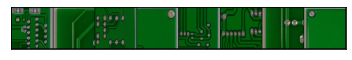

In [4]:
# sample check
sample, label = next(iter(train_loader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

In [5]:
# load wandb
import wandb
wandb.init()
wandb.run.name = 'CONVAE_2000_64_1000_se'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [6]:
#cuda init
import gc
gc.collect()
torch.cuda.empty_cache()

In [7]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=64*116*116, zDim=256):  #32 * (128-8 )*(128-8)iiji
        super(VAE, self).__init__()
        #encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encConv3 = nn.Conv2d(32, 64, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        #decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(64, 32, 5)
        self.decConv2 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv3 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = F.relu(self.encConv3(x))
        x = x.view(-1, 64*116*116) # 128-8
        mu = self.encFC1(x)  # 256
        logVar = self.encFC2(x)  # 256
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):
        x = F.relu(self.decFC1(z)) #32 20 20
        x = x.view(-1, 64, 116, 116) # 128-8
        x = F.relu(self.decConv1(x)) # 32 16 5
        x = torch.sigmoid(self.decConv2(x)) # 16 3 5  
        x = torch.sigmoid(self.decConv3(x)) # 16 3 5  
        return x  ##  1 deconv >> kernel +4 >> 2deconv Kernel +8

    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [8]:

batch_size = 10
learning_rate = 1e-3
num_epochs = 1500



net = VAE().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


total_steps = len(train_loader)
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):

        imgs, _ = data
        imgs = imgs.cuda()

        out, mu, logVar = net(imgs)
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({
            "Test Loss": loss/(total_steps*10),
            "kl_divergence": kl_divergence/total_steps})

    print('Epoch {}: Loss {}'.format(epoch, loss))
    print('Epoch {}: kl_divergence {}'.format(epoch, kl_divergence))

/home/pojaehanwer/anaconda3/envs/VAECONV/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 169301.734375
Epoch 0: kl_divergence 19.792640686035156
Epoch 1: Loss 174555.5625
Epoch 1: kl_divergence 685.248046875
Epoch 2: Loss 168850.984375
Epoch 2: kl_divergence 764.1767578125
Epoch 3: Loss 157068.875
Epoch 3: kl_divergence 695.8072509765625
Epoch 4: Loss 163555.875
Epoch 4: kl_divergence 424.248779296875
Epoch 5: Loss 158945.046875
Epoch 5: kl_divergence 343.67327880859375
Epoch 6: Loss 168848.9375
Epoch 6: kl_divergence 374.66351318359375
Epoch 7: Loss 151176.234375
Epoch 7: kl_divergence 765.2655029296875
Epoch 8: Loss 158093.734375
Epoch 8: kl_divergence 512.387451171875
Epoch 9: Loss 149971.09375
Epoch 9: kl_divergence 582.8328857421875
Epoch 10: Loss 141514.75
Epoch 10: kl_divergence 512.91943359375
Epoch 11: Loss 146350.15625
Epoch 11: kl_divergence 1065.6640625
Epoch 12: Loss 153609.71875
Epoch 12: kl_divergence 1288.6055908203125
Epoch 13: Loss 152347.609375
Epoch 13: kl_divergence 1587.2099609375
Epoch 14: Loss 142479.3125
Epoch 14: kl_divergence 755.03

In [13]:
#save model
# net --> model name
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')
saved_loc = os.path.join('./weight', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)
print(net)
PATH = saved_loc + '/' #'/home/jaehan/vae_pytorch_custom/caveweight/'

torch.save(net, PATH + 'model.pt')
torch.save(net.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  

저장 위치:  ./weight/2022-06-08-04:32
VAE(
  (encConv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encConv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (encFC1): Linear(in_features=861184, out_features=256, bias=True)
  (encFC2): Linear(in_features=861184, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=861184, bias=True)
  (decConv1): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv3): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
)


In [4]:
# #load model
# net = VAE().cuda()

# batch_size = 1
# learning_rate = 1e-3
# num_epochs = 10
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# PATH = '/home/pojaehanwer/Make_Conv_VAE/weight/2022-06-07-23:38/'
# net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
# net.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

# checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
# net.load_state_dict(checkpoint['model'])
# optimizer.load_state_dict(checkpoint['optimizer'])

In [106]:
#test loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(root='/home/pojaehanwer/Downloads/DATASET_PCB_2/test/crop/New', transform = transformer)

test_loader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)

In [107]:
# Missing_hole

# Mouse_bite

# Open_circuit

# Short

# Spur

# Spurious_copper

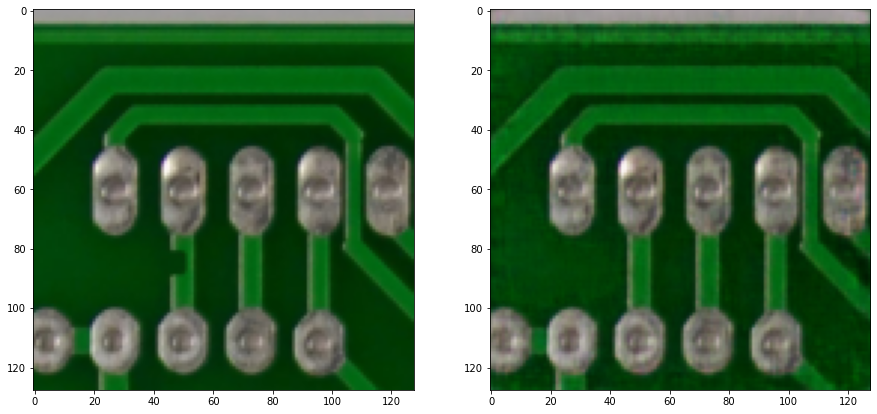

In [109]:
# make image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

plt.rcParams["figure.figsize"] = (15, 15)
net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.cuda()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        plt.imsave('img.png', img)

        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        plt.imsave('outimg.png', outimg)
        # cv2.imwrite("outimg.jpg", outimg)
        break

second


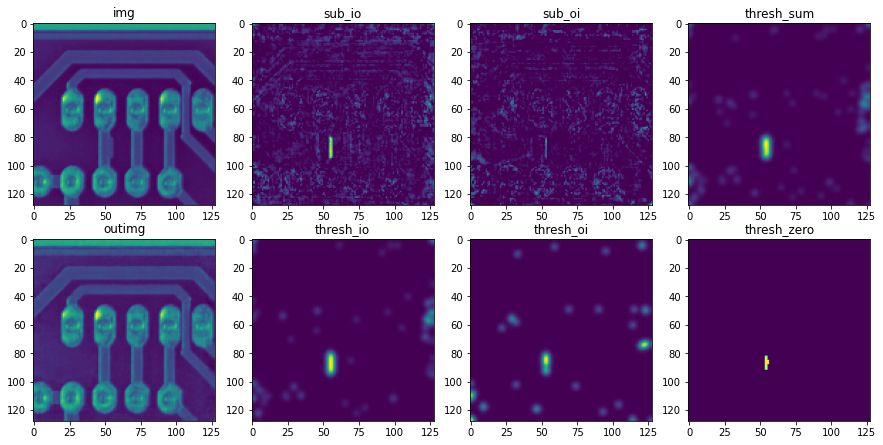

In [108]:
print("second")# subtract image all sub
import cv2
import numpy as np
import matplotlib.pyplot as plt
# print(img)
plt.rcParams["figure.figsize"] = (15, 15)
name = "Spur"
img = cv2.imread('./64_1500_RESULT/' +name+'img.png', cv2.IMREAD_GRAYSCALE)
outimg = cv2.imread('./64_1500_RESULT/'+name+'outimg.png', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('./result_1/epoch2000/imgOC.jpg', cv2.IMREAD_GRAYSCALE)
# outimg = cv2.imread('./result_1/epoch2000/outimgOC.jpg', cv2.IMREAD_GRAYSCALE)

# print(img)
plt.subplot(241)
plt.title('img')#, loc='right', pad=20)
plt.imshow(img)

plt.subplot(245)
plt.title('outimg')
plt.imshow(outimg)

sub_oi = cv2.subtract(outimg, img)
sub_io = cv2.subtract(img, outimg)

thresh_n = 10
thresh_oi = np.zeros_like(sub_oi) 
thresh_oi[sub_oi > thresh_n] = 255
# thresh_oi[thresh_oi < 254] = 0
thresh_oi = cv2.GaussianBlur(thresh_oi, (0, 0), 2)



thresh_io = np.zeros_like(sub_io) 
thresh_io[sub_io > thresh_n] = 255
# thresh_io[thresh_io < 254] = 0
thresh_io = cv2.GaussianBlur(thresh_io, (0, 0), 2)

plt.subplot(242)
plt.title('sub_io')
plt.imshow(sub_io)

plt.subplot(243)
plt.title('sub_oi')
plt.imshow(sub_oi)

plt.subplot(246)
plt.title('thresh_io')
plt.imshow(thresh_io)

plt.subplot(247)
plt.title('thresh_oi')
plt.imshow(thresh_oi)

thresh_sum = thresh_io + thresh_oi

thresh_zero = np.zeros_like(thresh_sum) 
thresh_zero[thresh_sum > 140] = 255      #sum threshold
# thresh_sum = cv2.medianBlur(thresh_sum, ksize = 3)
# plt.subplot(248)
# plt.imshow(thresh_filter)
plt.subplots_adjust(left=0.125, bottom=0.5,  right=0.9, top=0.9, wspace=0.2, hspace=0)
plt.subplot(244)
plt.title('thresh_sum')
plt.imshow(thresh_sum)
plt.subplot(248)
plt.title('thresh_zero')
# plt.imshow(thresh_sum)
plt.imshow(thresh_zero)
plt.savefig('test.png', dpi=300)

# plt.imsave('thresh_np.jpg', thresh_np)
# print(thresh_np.shape)

In [109]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

print(thresh_zero.shape)

#make list size
listsize = 0
for i in range(0, 127):
    for j in range(0,127):
        if thresh_zero[i][j] > 100:
            listsize +=1
make_mask = np.zeros_like(thresh_zero) 
count = 0


#make list(for select defect roi)
minmax_i = [0]*listsize
minmax_j = [0]*listsize


#select defect pixel
for i in range(0, 127):
    for j in range(0,127):
        if thresh_zero[i][j] > 100:
            # print(thresh_zero[i][j])
            minmax_i[count] = i
            minmax_j[count] = j
            count +=1
max_i = max(minmax_i)
max_j = max(minmax_j)
min_i = min(minmax_i)
min_j = min(minmax_j)
            
print(minmax_i)
print(minmax_j)
print(max_i)
print(min_i)
print(max_j)
print(min_j)

(128, 128)
[82, 82, 83, 83, 84, 84, 85, 85, 85, 86, 86, 86, 87, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91]
[54, 55, 54, 55, 54, 55, 54, 55, 56, 54, 55, 56, 54, 55, 56, 54, 55, 54, 55, 54, 55, 54, 55]
91
82
56
54


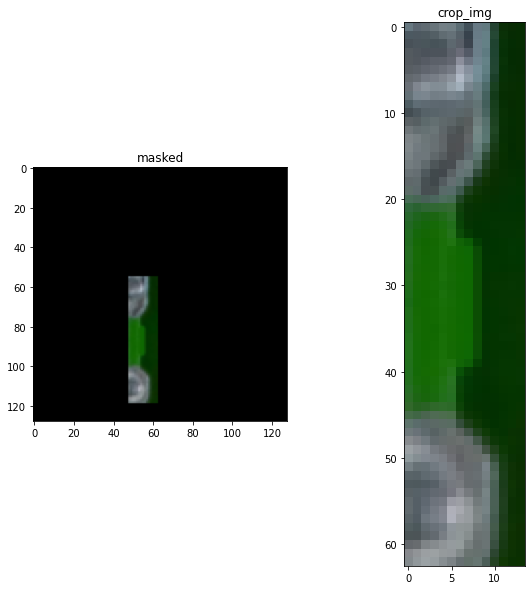

In [123]:
## make mask for color img
img = cv2.imread('./64_1500_RESULT/'+name+'img.png', cv2.IMREAD_COLOR)
defect_mask = np.zeros_like(img)

plt.rcParams["figure.figsize"] = (10, 10)

# Adaptive Mask Size
width = 3*(max_j - min_j)
hight = 3*(max_i - min_i)

# masking process
rect_point_a = (min_j - width, min_i- hight)
rect_point_b = ( max_j + width, max_i+ hight)
mask_rect = cv2.rectangle(defect_mask, rect_point_a, rect_point_b,(255,255,255), -1)

# defect crop process
crop_img = img[min_i- hight:max_i+ hight, min_j - width:max_j + width]


masked = cv2.bitwise_and(img, mask_rect)

plt.subplot(121)
plt.title('masked')
plt.imshow(masked)

plt.subplot(122)
plt.title('crop_img')
plt.imshow(crop_img)